# **IV–RV Mispricing**

The IV–RV spread refers to the gap between **implied volatility (IV)**, which reflects the market’s expectation of future variance, and **realized volatility (RV)**, which measures the actual variance observed in past returns. On average, IV tends to exceed RV because option sellers demand compensation for bearing tail risk and for taking the other side of persistent hedging flows. This difference is known as the **Variance Risk Premium (VRP)**.  

## Why Trade the IV–RV Spread?

While the VRP exists structurally, it is **time-varying** and can deviate significantly from fair value.  
- In calm markets, IV may remain elevated relative to RV, leading to overpriced options.  
- After shocks or during regime shifts, IV may lag realized outcomes and even understate true risk.  

By forecasting RV with historical and high-frequency data, traders can identify periods when the IV–RV spread is abnormally wide or inverted. Trading these dislocations through delta-hedged long or short volatility positions allows us to selectively capture the VRP while avoiding its most dangerous drawdowns.  

As options traders, we are not merely collecting the variance risk premium passively, we are exploiting **mispricings in its dynamics**, aiming for superior risk-adjusted returns by timing when IV is too rich or too cheap relative to expected realized volatility.  


The notebook is structured as follows:

1. [Read daily SPX Options chain & intraday SPX Index](#read_data)  
2. [Remove Illiquid Options](#plot_iv)
3. [The Variance Risk Premium (VRP) — Stylized Facts](#plot_vrp)
4. [Forecast Realized Volatility]()
4. [Generate Trading Signals](#eee)
5. [Apply Trading Filters](#dded)
6. [Realistic Backtest with walk forward & Risk management](#plot_iv)  
7. [Conclusion](#plot_iv)  

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import skew, kurtosis

from volatility_trading.iv_surface.iv_surface_interpolator import IVSurfaceInterpolator
import volatility_trading.strategies.vrp_mispricing.plotting as ph

from config.paths import DATA_INTER

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year `2023`.

In [7]:
file = DATA_INTER / "full_spx_options_2019_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_iv", "p_iv",
]

options = pd.read_parquet(file, columns=cols)
spot = options.groupby("date")["underlying_last"].first()

options["T"] = options["dte"] / 252
options["k"] = np.log(options["strike"] / options["underlying_last"])

In [3]:
options

,strike,underlying_last,dte,expiry,c_iv,p_iv,T,k
date,,,,,,,,
2019-01-02,1500.0,2509.98,0.0,2019-01-02,NaN,2.89277,0.000000,-0.514810
2019-01-02,1550.0,2509.98,0.0,2019-01-02,NaN,2.71843,0.000000,-0.482020
2019-01-02,1600.0,2509.98,0.0,2019-01-02,NaN,2.54775,0.000000,-0.450271
2019-01-02,1650.0,2509.98,0.0,2019-01-02,NaN,2.38434,0.000000,-0.419499
2019-01-02,1700.0,2509.98,0.0,2019-01-02,NaN,2.22082,0.000000,-0.389647
...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.17401,NaN,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.17063,NaN,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.16688,NaN,8.666667,0.465347


# **3. The Variance Risk Premium (VRP) — Stylized Facts**

Here we investigate the *stylized facts* — the key statistical properties of the VRP that can be modeled and potentially exploited for trading strategies.

### **Extract the interpolated 30D ATM IV for each day**

Since we don’t always observe an option with exactly 30 days to expiry, we fit an IV surface and interpolate in **total variance space** between the two closest ATM maturities bracketing 30 DTE.

In [4]:
def extract_atm_iv(options, model, target_T):
    iv_series = []

    for date, chain in options.groupby("date"):
        # Fit the surface for that day's chain
        model.fit(chain)

        # ATM strike = spot (or forward for target_T if desired)
        spot_price = chain["underlying_last"].iloc[0]

        # Extract ATM IV from fitted surface
        iv_atm = model.implied_vol(K=spot_price, T=target_T)

        iv_series.append((date, iv_atm))

    return pd.DataFrame(iv_series, columns=["date", "iv_atm"]).set_index("date")

In [5]:
iv_surface_interp = IVSurfaceInterpolator(method="linear")
iv_atm_30d = extract_atm_iv(options, iv_surface_interp, target_T=30/365)

### **Compute the 21-Day Realized Volatility**

We calculate **realized volatility** over a rolling **21-trading-day** window (which is approx 30 calendar days) using the underlying’s daily returns. This measure is annualized and represents the actual volatility observed over the past month, which will be compared to the 30-DTE implied volatility.

In [6]:
def realized_volatility(spot, window=21, method="forward", ann_factor=252):
    """Compute annualized realized volatility from a spot price series."""
    ret = np.log(spot / spot.shift(1))
    rv = np.sqrt(
        ret.pow(2).rolling(window, min_periods=window).sum() * 
        (ann_factor / window)
    )
    if method == "backward":
        return rv
    elif method == "forward":
        return rv.shift(-window)
    else:
        ValueError("method must be 'forward' or 'backward'.")

In [7]:
rv_21d = realized_volatility(spot, method="backward")

### **Compute the Variance Risk Prenium (VRP)**

In [8]:
def compute_vrp(iv, rv):
    # Compute VRP (aligning indexes)
    vrp = iv['iv_atm'].align(rv, join='inner')[0] - iv['iv_atm'].align(rv, join='inner')[1]
    return vrp

## **3.1 Stylized facts 1 & 2: Positive and time-varying VRP**

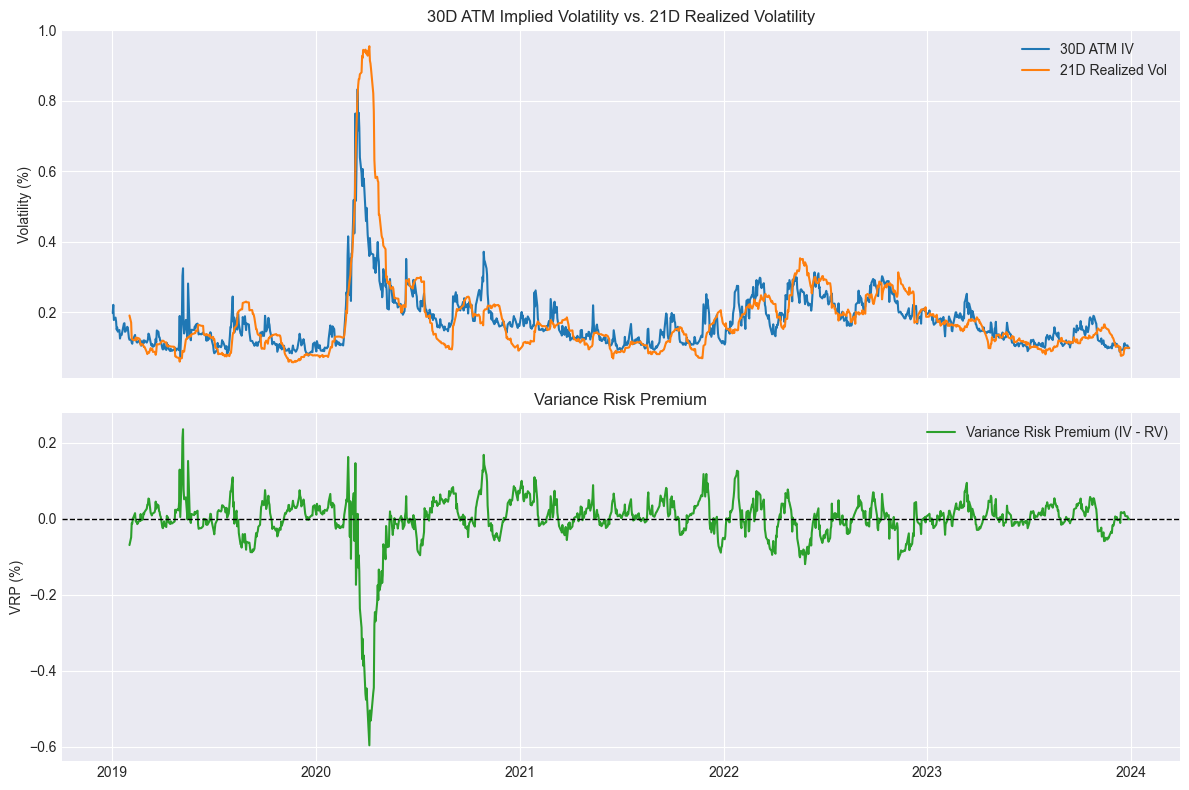

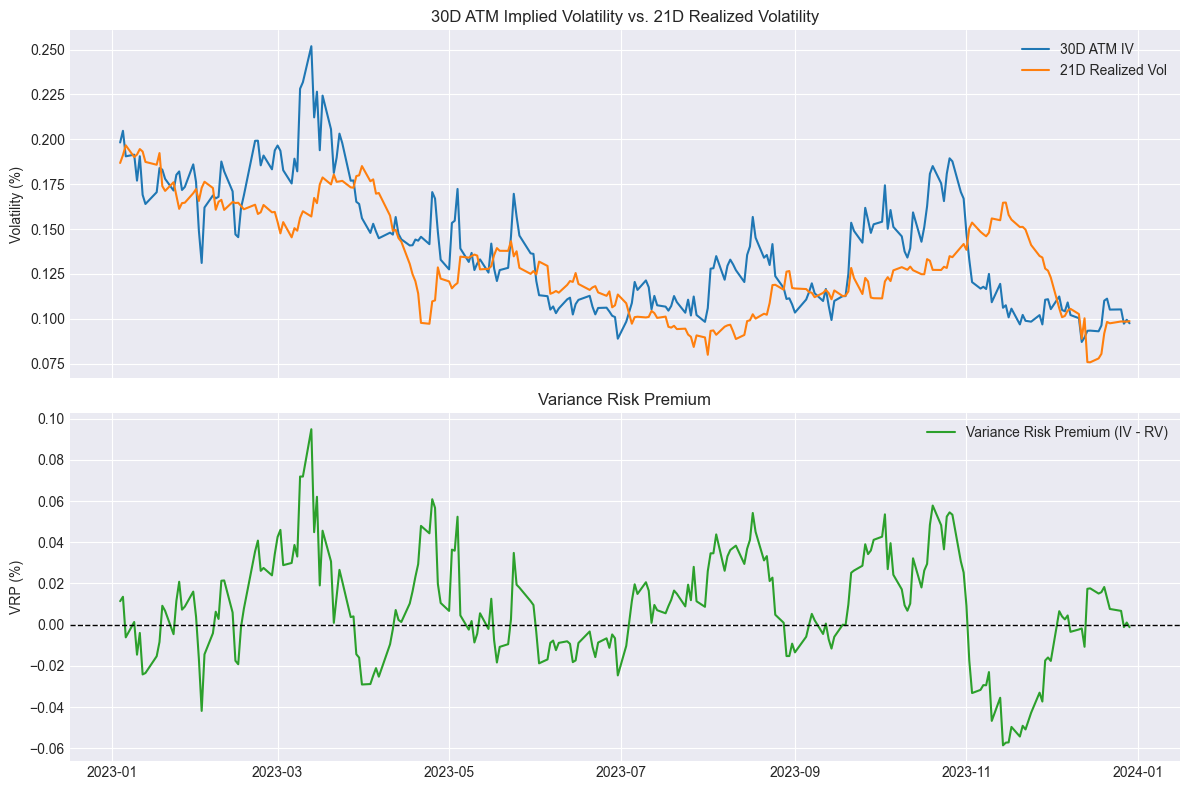

In [10]:
vrp_30d = compute_vrp(iv_atm_30d, rv_21d)

ph.plot_vrp(iv_atm_30d, rv_21d, vrp_30d)
ph.plot_vrp(iv_atm_30d.loc["2023"], rv_21d.loc["2023"], vrp_30d.loc["2023"])

During calm markets, the VRP is typically positive, whereas during crashes (e.g., the COVID-19 lockdown) realized volatility can exceed implied volatility when the market fails to anticipate the shock. It migth sugguest that a strategy consiting in selling preniums can be profitabel over the long run.

## **3.2 Stylized fact 3: Asymmetric VRP Behaviour**

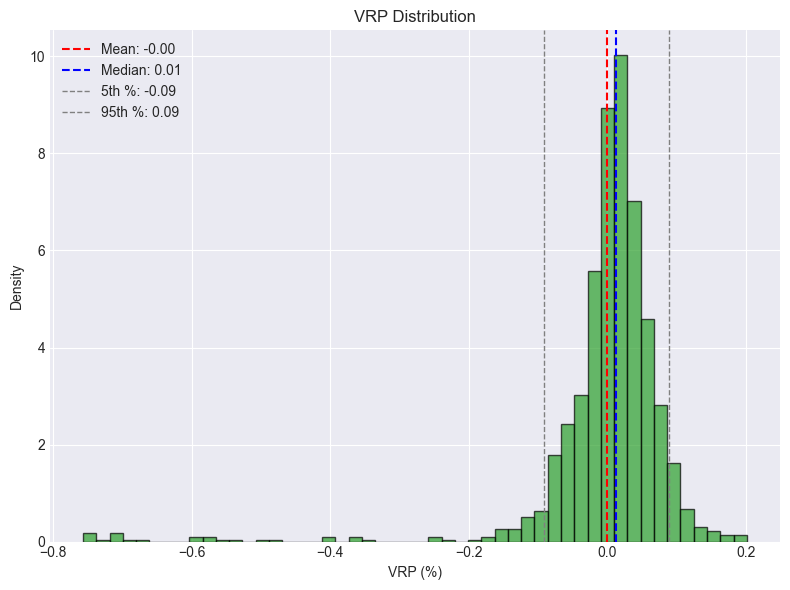

In [32]:
ph.plot_vrp_hist(vrp_30d)

In [11]:
print("Skewness VRP:", round(skew(vrp_30d.dropna()), 2))
print("Excess Kurtosis VRP:", round(kurtosis(vrp_30d.dropna()), 2))

Skewness VRP: -3.86
Excess Kurtosis VRP: 24.81


This sugguets that despite VRP beign mostly positive due to IV > RV, durign market crashes the RV >> IV leading to substancial losses. This migth sugguets that a tight risk control is necessary to prevent losses when selling preniums.

## **3.3 Stylized facts 4 & 5: Mean-reversion and Persistence**

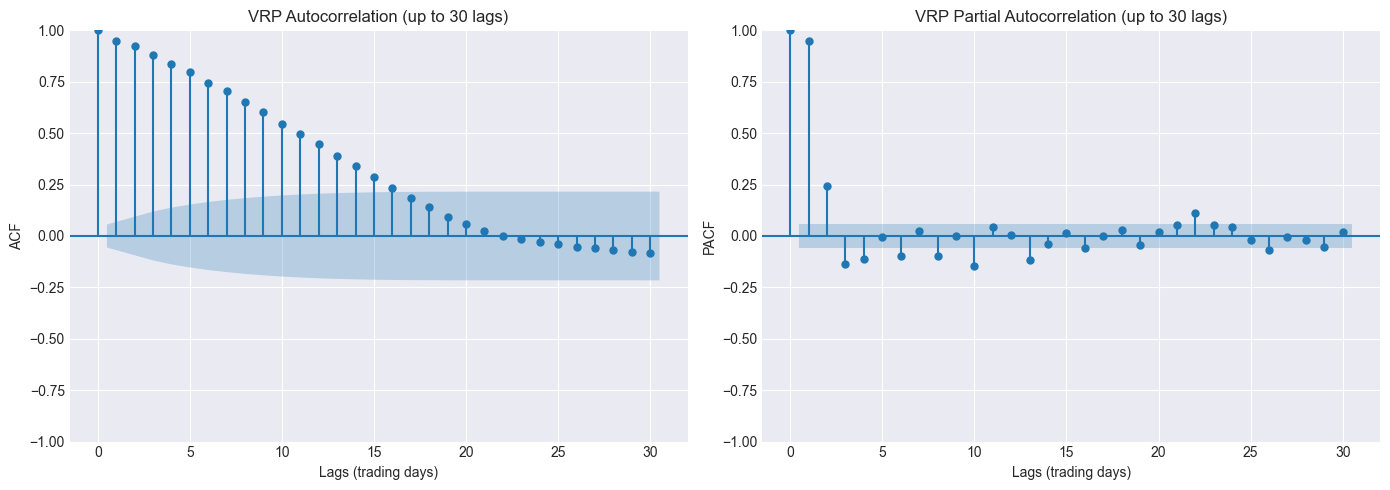

In [33]:
ph.plot_vrp_autocorr(vrp_30d, lags=30)

ACF decayign toward s0 like and PACF meaning different from 0 onyl for some lags is a typical behviour in AR-mean revrting processes.

In [34]:
def fit_ar1_vrp(vrp):
    vrp = vrp.dropna()
    
    # Fit AR(1) model
    model = AutoReg(vrp, lags=1, old_names=False)
    res = model.fit()
    
    phi = res.params['y.L1']
    intercept = res.params['const']
    
    # Half-life calculation for mean reversion
    if phi < 1:
        halflife = -np.log(2) / np.log(abs(phi))
    else:
        halflife = np.inf
    
    print(res.summary())
    print(f"\nAR(1) coefficient (phi): {phi:.4f}")
    print(f"Half-life: {halflife:.2f} days")
    return res

# Example usage
res = fit_ar1_vrp(vrp_30d)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1227
Model:                     AutoReg(1)   Log Likelihood                2496.309
Method:               Conditional MLE   S.D. of innovations              0.032
Date:                Wed, 22 Oct 2025   AIC                          -4986.619
Time:                        12:19:47   BIC                          -4971.284
Sample:                             1   HQIC                         -4980.848
                                 1227                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.484e-05      0.001     -0.039      0.969      -0.002       0.002
y.L1           0.9489      0.009    105.237      0.000       0.931       0.967
                                    Roots           

/Users/anthony/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


A p-value less than 1% sugguets that the VRP has mean reverting properties whihc can be used in a **stat-arb context**.

```python
if (VIX > 20 and VIX > VIX_roll_mean5d and VIX 5d change > +10%) or VIX > 30:
    signal = False
```